In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import plotly.figure_factory as ff


from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [37]:
dataframe = pd.read_csv('DataFrame.csv')

In [38]:
dataframe.head(5)

,Type,Date,Time,open,high,low,close,Unnamed: 7
0,NIFTY,20210101,09:16,13997.90,14020.85,13991.35,14013.15,NaN
1,NIFTY,20210101,09:17,14014.85,14018.55,14008.15,14009.05,NaN
2,NIFTY,20210101,09:18,14008.05,14013.10,14005.05,14012.70,NaN
3,NIFTY,20210101,09:19,14013.65,14019.10,14013.65,14016.20,NaN
4,NIFTY,20210101,09:20,14015.45,14017.80,14011.95,14015.45,NaN


##### check the null values

In [39]:
dataframe.isnull().sum()

Type              0
Date              0
Time              0
open              0
high              0
low               0
close             0
Unnamed: 7    22805
dtype: int64

* nifty dataset dont have null values

* but we can see that 'Unnamed: 7','Type' are not required for our analysis. so we will drop both the column

In [40]:
dataframe = dataframe.drop(['Unnamed: 7','Type'],axis=1)

In [41]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22805 entries, 0 to 22804
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    22805 non-null  int64  
 1   Time    22805 non-null  object 
 2   open    22805 non-null  float64
 3   high    22805 non-null  float64
 4   low     22805 non-null  float64
 5   close   22805 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.0+ MB


###### check the outliers

<AxesSubplot:>

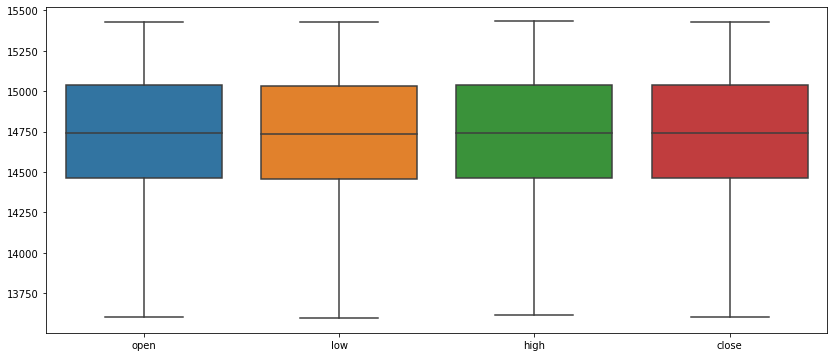

In [42]:
plt.figure(figsize=(14,6))
sns.boxplot(data=dataframe[["open","low","high","close"]])

* no outliers found

###### Now we need to convert date column into the date time formate

In [43]:
dataframe['Date'] = pd.to_datetime(dataframe['Date'], format='%Y%m%d')
dataframe.head()

,Date,Time,open,high,low,close
0,2021-01-01,09:16,13997.90,14020.85,13991.35,14013.15
1,2021-01-01,09:17,14014.85,14018.55,14008.15,14009.05
2,2021-01-01,09:18,14008.05,14013.10,14005.05,14012.70
3,2021-01-01,09:19,14013.65,14019.10,14013.65,14016.20
4,2021-01-01,09:20,14015.45,14017.80,14011.95,14015.45


##### describe method to understand the data with statistic term

In [58]:
dataframe.describe()

,open,high,low,close
count,22805.000000,22805.000000,22805.000000,22805.000000
mean,14703.322396,14707.486481,14699.102201,14703.260816
std,391.377498,391.265231,391.551643,391.366248
min,13604.750000,13614.400000,13596.750000,13602.800000
25%,14462.250000,14465.950000,14458.050000,14461.950000
50%,14739.500000,14743.000000,14735.850000,14739.450000
75%,15037.000000,15041.250000,15032.500000,15036.850000
max,15429.500000,15431.750000,15427.900000,15430.200000


###### lets analysis the date in nifty dataset. Its important in time series data

In [44]:
year = dataframe['Date'].dt.year
year.unique()

array([2021], dtype=int64)

In [51]:
month = dataframe['Date'].dt.month
month.unique()

array([1, 2, 3], dtype=int64)

In [54]:
day_of_week = dataframe['Date'].dt.dayofweek
day_of_week.unique()

array([4, 0, 1, 2, 3], dtype=int64)

In [55]:
day = dataframe['Date'].dt.day
day.unique()

array([ 1,  4,  5,  6,  7,  8, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 25,
       27, 28, 29,  2,  3,  9, 10, 16, 17, 23, 24, 26, 30, 31],
      dtype=int64)

* here we can conclude that 
* we are analysing 2021 year data
* for 3 months i.e, January, February and March
* for 5 week of month
* for all 31 days

#### data visualization

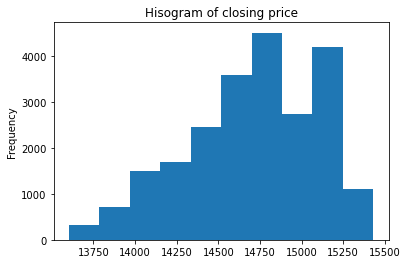

In [47]:
plt.figure
df_close = dataframe['close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

<AxesSubplot:>

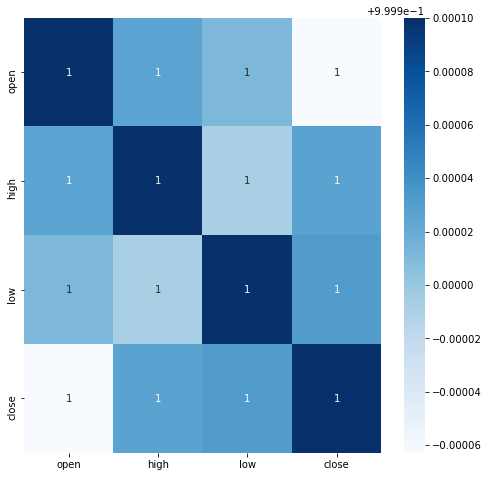

In [48]:
plt.figure(figsize=(8,8))
sns.heatmap(dataframe.corr(),annot=True,cmap='Blues')
#sns.heatmap(df.corr(),cmap='Blues',annot=True)

In [49]:
cor_matrix = dataframe.corr()

In [50]:
cor_matrix

,open,high,low,close
open,1.000000,0.999926,0.999912,0.999837
high,0.999926,1.000000,0.999893,0.999927
low,0.999912,0.999893,1.000000,0.999932
close,0.999837,0.999927,0.999932,1.000000


<AxesSubplot:>

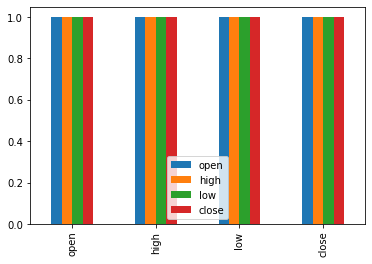

In [67]:
cor_matrix.plot.bar()

* all four feature is highly correlated with each other

Text(0.5, 1.0, 'NIFTY closing price')

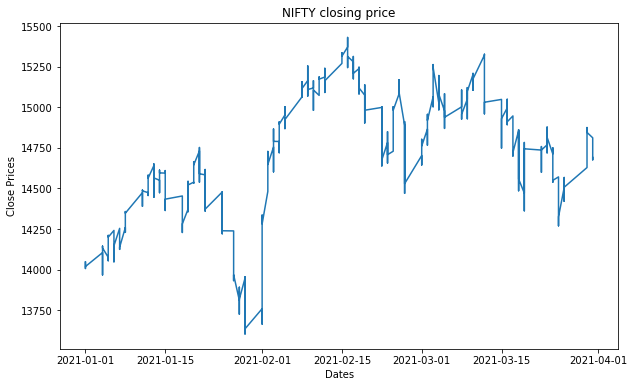

In [65]:
plt.figure(figsize=(10,6))
plt.plot(dataframe["Date"],dataframe["close"])
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.title('NIFTY closing price')

* we can see all time low closing value at the 2021-02-01.

* Now last part is to make our data stational before going to modelling part. 
* Augmented Dickey-Fuller Test(ADF Test) 
* It is the most common statistical test to determine whether a time series is stationary or not. It works with taking a null hypothesis that tells that the series is not stationary. A minimal value of p(<0.005) is required to reject that null hypothesis. The test also considers the ADF statistics must be less than different critical values. In python, we can apply the ADF test using the Statsmodels library.

In [66]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(dataframe['close'])
print('ADF Statistics: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
for key, value in result[4].items():
    print('Critical Values Over {}: {}'.format(key, value))

ADF Statistics: -2.126148779260194
p-value: 0.2341308515461299
Critical Values Over 1%: -3.430636931803934
Critical Values Over 5%: -2.861666814628871
Critical Values Over 10%: -2.5668374998130825


In [68]:
close_log = np.log(dataframe['close'])
result = adfuller(close_log)
print('ADF Statistics: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
for key, value in result[4].items():
    print('Critical Values Over {}: {}'.format(key, value))

ADF Statistics: -2.1349024292094603
p-value: 0.23071365598070998
Critical Values Over 1%: -3.430636931803934
Critical Values Over 5%: -2.861666814628871
Critical Values Over 10%: -2.5668374998130825


In [70]:
rolling_mean = close_log.rolling(window=365).mean()
close_log_minus_mean = close_log - rolling_mean
close_log_minus_mean.dropna(inplace=True)

result = adfuller(close_log_minus_mean)
print('ADF Statistics: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
for key, value in result[4].items():
    print('Critical Values Over {}: {}'.format(key, value))

ADF Statistics: -6.0939560297970266
p-value: 1.0206302019137448e-07
Critical Values Over 1%: -3.4306415889501976
Critical Values Over 5%: -2.861668872836643
Critical Values Over 10%: -2.5668385953559967


* The rolling mean and standard deviation now become quite consistent, the ADF statistic is lower than the critical values and the p-value is lower than the threshold.